In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize
from collections import Counter
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
import nltk
from functools import reduce

# Load PyDrive and Google Auth related packages
#!pip install -U -q PyDrive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

# Load the json data
def load_json_file(name):
  """
  Load the json file and return a json object
  """
  with open(name,encoding='utf-8') as myfile:
    data = json.load(myfile)
    return data

# Convert json data object to a pandas data frame
def convert_to_pd(data):
  """
  Load the data to a pandas dataframe.
  Dataframe Columns:
    title
    para_index
    context
    q_index
    q_id
    q_isimpossible
    q_question
    q_anscount - number of answers
    q_answers - a list of object e.g [{ text: '', answer_start: 123}, ...]
  """
  result = []
  for pdata in data['data']:
    for para in pdata['paragraphs']:
      for q in para['qas']:
        result.append({
            'title' : pdata['title'],
            'context' : para['context'],
            'q_id' : q['id'],
            'q_isimpossible' : q['is_impossible'],
            'q_question' : q['question'],
            'q_anscount' : len(q['answers']),
            'q_answers' : [a for a in q['answers']],
            'q_answers_text': [a.get("text") for a in q['answers']],
            'context_lowercase': para['context'].lower(),
            'q_question_lowercase' : q['question'].lower(),
            'q_answers_text_lowercase': [a.get("text").lower() for a in q['answers']],
            
        })

  return pd.DataFrame.from_dict(result, orient='columns')

# Load the file from shareable google drive link and return a pandas dataframe
def loadDataFile(filename): 
  """
  Download a file from google drive with the shared link
  """ 
  data = load_json_file(filename)
  return convert_to_pd(data)

In [3]:
train_filename = 'train-v2.0.json'
dev_filename = 'dev-v2.0.json'

train_pd = loadDataFile(train_filename)
dev_pd = loadDataFile(dev_filename)

In [3]:
train_pd

,title,context,q_id,q_isimpossible,q_question,q_anscount,q_answers,q_answers_text,context_lowercase,q_question_lowercase,q_answers_text_lowercase
0,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56be85543aeaaa14008c9063,False,When did Beyonce start becoming popular?,1,"[{'text': 'in the late 1990s', 'answer_start':...",[in the late 1990s],beyoncé giselle knowles-carter (/biːˈjɒnseɪ/ b...,when did beyonce start becoming popular?,[in the late 1990s]
1,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56be85543aeaaa14008c9065,False,What areas did Beyonce compete in when she was...,1,"[{'text': 'singing and dancing', 'answer_start...",[singing and dancing],beyoncé giselle knowles-carter (/biːˈjɒnseɪ/ b...,what areas did beyonce compete in when she was...,[singing and dancing]
2,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56be85543aeaaa14008c9066,False,When did Beyonce leave Destiny's Child and bec...,1,"[{'text': '2003', 'answer_start': 526}]",[2003],beyoncé giselle knowles-carter (/biːˈjɒnseɪ/ b...,when did beyonce leave destiny's child and bec...,[2003]
3,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56bf6b0f3aeaaa14008c9601,False,In what city and state did Beyonce grow up?,1,"[{'text': 'Houston, Texas', 'answer_start': 166}]","[Houston, Texas]",beyoncé giselle knowles-carter (/biːˈjɒnseɪ/ b...,in what city and state did beyonce grow up?,"[houston, texas]"
4,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56bf6b0f3aeaaa14008c9602,False,In which decade did Beyonce become famous?,1,"[{'text': 'late 1990s', 'answer_start': 276}]",[late 1990s],beyoncé giselle knowles-carter (/biːˈjɒnseɪ/ b...,in which decade did beyonce become famous?,[late 1990s]
...,...,...,...,...,...,...,...,...,...,...,...
130314,Matter,"The term ""matter"" is used throughout physics i...",5a7e070b70df9f001a875439,True,Physics has broadly agreed on the definition o...,0,[],[],"the term ""matter"" is used throughout physics i...",physics has broadly agreed on the definition o...,[]
130315,Matter,"The term ""matter"" is used throughout physics i...",5a7e070b70df9f001a87543a,True,Who coined the term partonic matter?,0,[],[],"the term ""matter"" is used throughout physics i...",who coined the term partonic matter?,[]
130316,Matter,"The term ""matter"" is used throughout physics i...",5a7e070b70df9f001a87543b,True,What is another name for anti-matter?,0,[],[],"the term ""matter"" is used throughout physics i...",what is another name for anti-matter?,[]
130317,Matter,"The term ""matter"" is used throughout physics i...",5a7e070b70df9f001a87543c,True,Matter usually does not need to be used in con...,0,[],[],"the term ""matter"" is used throughout physics i...",matter usually does not need to be used in con...,[]


In [4]:
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from functools import reduce
flatten = lambda data: reduce(lambda x, y: x + y, data)
import glove_helper
import importlib

In [5]:
def get_c_q_a(dataset):
    q_id_list = []
    context_list =[]
    questions_list = []
    answers_list =[]
    q_impossible_list =[]
    for index,row in dataset.iterrows():
        q_id_list.append(row.q_id)
        context_list.append(row.context)
        questions_list.append(row.q_question)
        q_impossible_list.append(int(row.q_isimpossible))
        if len(row.q_answers_text)>0 :
            answers_list.append(row.q_answers_text[0])
        else:
            answers_list.append("")
    return [q_id_list,context_list,questions_list,q_impossible_list,answers_list]
    

In [6]:
train_lists = get_c_q_a(train_pd)
dev_lists = get_c_q_a(dev_pd)


In [7]:
context_maxlen = max(map(len, (x.split() for x in train_lists[1])))
question_maxlen = max(map(len, (x.split() for x in train_lists[2])))
answer_maxlen = max(map(len, (x.split() for x in train_lists[4])))

In [8]:
print("Max context length:",context_maxlen)
print("Max question length:",question_maxlen)
print("Max answer length:",answer_maxlen)

Max context length: 653
Max question length: 40
Max answer length: 43


In [9]:
def tokenize_c_q_a(dataset,num_words=None):
    tokenizer = Tokenizer(num_words,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"''",oov_token='<unk>')
    data = dataset[1]+dataset[2]+dataset[4]
    tokenizer.fit_on_texts(data)
    vocab = {}
    for word,i in tokenizer.word_index.items():
        if i <= num_words:
            vocab[word] = i
    #vocab = tokenizer.word_index
    vocab['<s>'] = len(vocab)+1
    vocab['</s>'] = len(vocab)+1
    id_vocab = {value: key for key, value in vocab.items()}
    return (tokenizer,vocab,id_vocab)

In [10]:
#tokenizer_obj = tokenize_c_q_a([a+b for a,b in zip(train_lists,dev_lists)])
tokenizer_obj,vocab,id_vocab = tokenize_c_q_a(dataset=train_lists,num_words=50000)

In [11]:
vocab_size = len(vocab)
print("Vocab Size:",vocab_size)

Vocab Size: 50002


In [19]:
vocab['<s>']

50001

In [12]:
def vectorize_data(tokenizer_obj,train_lists):
    context_seq = tokenizer_obj.texts_to_sequences(train_lists[1])
    question_seq = tokenizer_obj.texts_to_sequences(train_lists[2])
    answer_seq = tokenizer_obj.texts_to_sequences(train_lists[4])
    answer_input_seq = [[vocab['<s>']]+i+[vocab['</s>']] for i in answer_seq]
    answer_target_seq = [i+[vocab['</s>']] for i in answer_seq]
    context_seq_padded = pad_sequences(context_seq,context_maxlen,padding='post', truncating='post')
    question_seq_padded = pad_sequences(question_seq,question_maxlen,padding='post', truncating='post')
    answer_seq_padded = pad_sequences(answer_seq,answer_maxlen,padding='post', truncating='post')
    answer_input_seq_padded = pad_sequences(answer_input_seq,answer_maxlen+2,padding='post', truncating='post')
    answer_target_seq_padded = pad_sequences(answer_target_seq,answer_maxlen+2,padding='post', truncating='post')
    answer_impossible = np.array(train_lists[3])
    indices = np.arange(context_seq_padded.shape[0])
    np.random.shuffle(indices)
    context_seq_padded = context_seq_padded[indices]
    question_seq_padded = question_seq_padded[indices]
    answer_seq_padded = answer_seq_padded[indices]
    answer_input_seq_padded = answer_input_seq_padded[indices]
    answer_target_seq_padded = answer_target_seq_padded[indices]
    answer_impossible_shuffled = answer_impossible[indices]
    train_samples = int(context_seq_padded.shape[0]*.8)
    train_context_padded_seq = context_seq_padded[:train_samples]
    train_question_seq_padded = question_seq_padded[:train_samples]
    train_answer_seq_padded = answer_seq_padded[:train_samples]
    train_answer_input_seq_padded = answer_input_seq_padded[:train_samples]
    train_answer_target_seq_padded = answer_target_seq_padded[:train_samples]
    train_answer_impossible = answer_impossible_shuffled[:train_samples]
    val_context_padded_seq = context_seq_padded[train_samples:]
    val_question_seq_padded = question_seq_padded[train_samples:]
    val_answer_seq_padded = answer_seq_padded[train_samples:]
    val_answer_input_seq_padded = answer_input_seq_padded[train_samples:]
    val_answer_target_seq_padded = answer_target_seq_padded[train_samples:]
    val_answer_impossible = answer_impossible_shuffled[train_samples:]
    return (train_context_padded_seq,train_question_seq_padded,train_answer_seq_padded,
            train_answer_input_seq_padded,train_answer_target_seq_padded,train_answer_impossible,
            val_context_padded_seq,val_question_seq_padded,val_answer_seq_padded,
            val_answer_input_seq_padded,val_answer_target_seq_padded,val_answer_impossible)

In [13]:
train_context_padded_seq,train_question_seq_padded,train_answer_seq_padded,\
train_answer_input_seq_padded,train_answer_target_seq_padded,\
train_answer_impossible,\
val_context_padded_seq,val_question_seq_padded,val_answer_seq_padded,\
val_answer_input_seq_padded,val_answer_target_seq_padded,\
val_answer_impossible\
= vectorize_data(tokenizer_obj,train_lists)

In [14]:
    print(len(val_answer_seq_padded[val_answer_impossible==1]))
    print(len(val_answer_seq_padded[val_answer_impossible==0]))
    print(len(train_answer_seq_padded[train_answer_impossible==1]))
    print(len(train_answer_seq_padded[train_answer_impossible==0]))


8743
17321
34755
69500


In [15]:
def create_embedding_matrix(word_index,vocab_size=50000,ndim=100):
    hands = glove_helper.Hands(ndim)
    embedding_matrix = np.zeros((vocab_size+1,ndim))
    for word,i in word_index.items():
        if i<=vocab_size:
            embedding_vector = hands.get_vector(word,strict=False)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [16]:
importlib.reload(glove_helper)
embedding_matrix = create_embedding_matrix(vocab,vocab_size,100)

Loading vectors from data/glove/glove.6B.zip
Parsing file: data/glove/glove.6B.zip:glove.6B.100d.txt
Found 400,000 words.
Parsing vectors... Done! (W.shape = (400003, 100))


In [112]:
embedding_matrix.shape

(50003, 100)

In [17]:
class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V =  layers.Dense(1)

    def call(self, inputs):
        query = inputs[0]
        values = inputs[1]
        #print("query shape",query.shape)
        #print("vaues shape",values.shape)
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        #query_with_time_axis = tf.expand_dims(query, 1)
        #print("query_with_time_axis shape",query_with_time_axis.shape)
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(keras.activations.tanh(
        self.W1(query) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = keras.activations.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        #context_vector = tf.reduce_sum(context_vector, axis=1)
        #print("context vector shape",context_vector.shape)

        return context_vector

def create_memory_using_attention(num_episodes,query,context_outputs,attention_type,BahdanauUnits=32):
    m = layers.Lambda(lambda x: x)(query)
    Dense_Layer_concat_M_q = layers.Dense(units=query.shape[1],activation='tanh')
    if attention_type == 0:
        #use keras attention which is Luong's
        attention_layer = layers.Attention()
    else:
        # use BahdanauAttention
        attention_layer = BahdanauAttention(BahdanauUnits)
    for i in range(num_episodes):
        m_plus_q =layers.concatenate(inputs=[m,query],axis=1)
        if attention_type ==0:
            m_plus_q = Dense_Layer_concat_M_q(m_plus_q)
        m_plus_q_with_time_axis = tf.keras.backend.expand_dims(m_plus_q, 1)
        context_with_attention = attention_layer([m_plus_q_with_time_axis,context_outputs])
        m = tf.keras.backend.sum(context_with_attention, axis=1)
        
    
    return m

In [21]:
#Function to create the Models
num_unit_gru = 64
num_layers_gru = 2
ndim =100
num_episodes = 2
num_dense_layer_feasibility = 16
dropout_rate = 0.5
num_dense_layers_feasibility = 1
attentionType = 0 # 0 means Luong's 1 means BahdanauUnits
BahdanauUnits = 32

class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V =  layers.Dense(1)

    def call(self, inputs):
        query = inputs[0]
        values = inputs[1]
        #print("query shape",query.shape)
        #print("vaues shape",values.shape)
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        #query_with_time_axis = tf.expand_dims(query, 1)
        #print("query_with_time_axis shape",query_with_time_axis.shape)
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(keras.activations.tanh(
        self.W1(query) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = keras.activations.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        #context_vector = tf.reduce_sum(context_vector, axis=1)
        #print("context vector shape",context_vector.shape)

        return context_vector

def create_memory_using_attention(num_episodes,query,context_outputs,attention_type,BahdanauUnits=32):
    m = layers.Lambda(lambda x: x)(query)
    Dense_Layer_concat_M_q = layers.Dense(units=query.shape[1],activation='tanh')
    if attention_type == 0:
        #use keras attention which is Luong's
        attention_layer = layers.Attention()
    else:
        # use BahdanauAttention
        attention_layer = BahdanauAttention(BahdanauUnits)
    for i in range(num_episodes):
        m_plus_q =layers.concatenate(inputs=[m,query],axis=1)
        if attention_type ==0:
            m_plus_q = Dense_Layer_concat_M_q(m_plus_q)
        m_plus_q_with_time_axis = tf.keras.backend.expand_dims(m_plus_q, 1)
        context_with_attention = attention_layer([m_plus_q_with_time_axis,context_outputs])
        m = tf.keras.backend.sum(context_with_attention, axis=1)


    return m


#Input Module
context_input = Input(shape=(None,),dtype='int32',name='Context_Input')
context_embeddings = layers.Embedding(vocab_size+1,ndim,mask_zero=True,name='Context_Embedding')(context_input)

for i in range(num_layers_gru):
    context_outputs_layers = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                  recurrent_dropout= dropout_rate,
                                                  return_sequences=True),name='Context_Bid_Layer'+str(i))
    if i==0:
        context_outputs = context_outputs_layers(context_embeddings)
    else:
        context_outputs = context_outputs_layers(context_outputs)
print("Context output shape",context_outputs.shape)
#Question Module
question_input = Input(shape=(None,),dtype='int32',name='Question_Input')
question_embeddings = layers.Embedding(vocab_size+1,ndim,mask_zero=True,name='Question_Embedding')(question_input)

for i in range(num_layers_gru):
    if i==0 and num_layers_gru >1:
        question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                recurrent_dropout= dropout_rate,
                                                return_sequences=True),
                                                name='Question_Bid_Layer'+str(i))(question_embeddings)
    elif i==0 and num_layers_gru ==1:
        question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                recurrent_dropout= dropout_rate,
                                                return_sequences=False),
                                                name='Question_Bid_Layer'+str(i))(question_embeddings)
    elif i==(num_layers_gru-1):
        question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                recurrent_dropout= dropout_rate,
                                                return_sequences=False),
                                                name='Question_Bid_Layer'+str(i))(question_outputs)
    else:
        question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                recurrent_dropout= dropout_rate,
                                                return_sequences=True),
                                                name='Question_Bid_Layer'+str(i))(question_outputs)
#Episodic Memory Module
m=create_memory_using_attention(num_episodes,question_outputs,context_outputs,attentionType,BahdanauUnits)
#print(m.shape)
#print(context_outputs.shape)
#print(question_outputs.shape)
concatenated_tensor = layers.concatenate(inputs=[m,question_outputs],name='Concatenation_Memory_Question',axis=1)

#answer_module

answer_input = Input(shape=(None,),dtype='int32',name='Answer_Input')
answer_embeddings = layers.Embedding(vocab_size+1,ndim,mask_zero=True,name='Answer_Embedding')(answer_input)
for i in range(num_layers_gru):
    answer_decoder_layers = layers.GRU(concatenated_tensor.shape[1],dropout=dropout_rate,
                                       recurrent_dropout= dropout_rate,
                                       return_sequences=True,
                                       return_state=True,
                                       name='Answer_GRU_Layer'+str(i)
                                       )
    if i==0:
        answer_outputs,_ = answer_decoder_layers(answer_embeddings,initial_state=concatenated_tensor)
    else:
        answer_outputs,_ = answer_decoder_layers(answer_outputs)

answer_decoder_dense = layers.TimeDistributed(layers.Dense(vocab_size+1, activation='softmax')
                                              ,name='Answer_output')
answer_decoder_outputs = answer_decoder_dense(answer_outputs)

answer_model = Model([context_input,question_input,answer_input],answer_decoder_outputs)
answer_model.get_layer("Question_Embedding").set_weights([embedding_matrix])
answer_model.get_layer("Question_Embedding").trainable = False
answer_model.get_layer("Context_Embedding").set_weights([embedding_matrix])
answer_model.get_layer("Context_Embedding").trainable = False
answer_model.get_layer("Answer_Embedding").set_weights([embedding_matrix])
answer_model.get_layer("Answer_Embedding").trainable = False

#feasibility module
feasibility_input = Input(shape=(concatenated_tensor.shape[1],), name="FeasibilityInput")
for i in range(num_dense_layers_feasibility):
    if i==0:
        dense_layer = layers.Dense(num_dense_layer_feasibility,
                            activation='relu',name='feasibility_layer_'+str(i))(feasibility_input)
    else:
        dense_layer = layers.Dense(num_dense_layer_feasibility,
                            activation='relu',name='feasibility_layer_'+str(i))(dense_layer)
    dropout_layer = layers.Dropout(dropout_rate,name='feasibility_drop_'+str(i))(dense_layer)

feasibility_output = layers.Dense(1,activation='sigmoid',name='feasibility_output')(dropout_layer)

feasibility_model = Model(feasibility_input,feasibility_output)

encoder_model = Model([context_input,question_input], concatenated_tensor)
decoder_inputs = answer_input
decoder_state_input_h = Input(shape=(None,), name="DecoderStateInput")


for i in range(num_layers_gru):
    decoder_layers = answer_model.get_layer('Answer_GRU_Layer'+str(i))
    if i==0:
        decoder_outputs, decoder_state_h = decoder_layers(answer_embeddings,initial_state=decoder_state_input_h)
    else:
        decoder_outputs, decoder_state_h = decoder_layers(decoder_outputs)

decoder_dense =  answer_model.get_layer('Answer_output')(decoder_outputs)

decoder_model = Model(
                    [decoder_inputs] + [decoder_state_input_h],
                    [decoder_dense] + [decoder_state_h])

Context output shape (None, None, 128)


In [ ]:
#Function to get sentences from the predicted answers
def decode_sequence(context_input_seq,
                question_input_seq,
                encoder_model,
                decoder_model):
    # Encode the input as state vectors.
    states_value = encoder_model.predict([context_input_seq,question_input_seq])

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    current_step = 0
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab["<s>"]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h = decoder_model.predict([target_seq] + [states_value])
        current_step += 1
        # Sample a token
        #print(output_tokens.shape)
        #print(output_tokens[0,0,0])
        #print(output_tokens[0,0,32984])
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        #print(sampled_token_index)
        if sampled_token_index == 0:
          sampled_char = " "
        else:
          sampled_char = id_vocab[sampled_token_index]
        decoded_sentence += sampled_char + " "

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == '</s>' or len(decoded_sentence) > answer_maxlen:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = h

    return decoded_sentence

In [38]:
tf.config.optimizer.get_experimental_options()

{'disable_model_pruning': False, 'disable_meta_optimizer': False}

In [115]:
(178*.8)//128

1.0

In [65]:
tf.config.optimizer.set_experimental_options({'arithmetic_optimization':False,
                                              'dependency_optimization':False,
                                              'pin_to_host_optimization':False,
                                              'min_graph_nodes':-1,
                                            'disable_meta_optimizer':True})
num_unit_gru = 64
num_layers_gru = 2
ndim =100
num_episodes = 2
num_dense_layer_feasibility = 16
dropout_rate = 0.5
num_dense_layers_feasibility = 1
attentionType = 0 # 0 means Luong's 1 means BahdanauUnits
BahdanauUnits = 32
#Input Module
context_input = Input(shape=(None,),dtype='int32',name='Context_Input')
context_embeddings = layers.Embedding(vocab_size+1,ndim,mask_zero=True,name='Context_Embedding')(context_input)

for i in range(num_layers_gru):
    context_outputs_layers = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                  recurrent_dropout= dropout_rate,
                                                  return_sequences=True),name='Context_Bid_Layer'+str(i))
    if i==0:
        context_outputs = context_outputs_layers(context_embeddings)
    else:
        context_outputs = context_outputs_layers(context_outputs)
print("Context output shape",context_outputs.shape)
#Question Module
question_input = Input(shape=(None,),dtype='int32',name='Question_Input')
question_embeddings = layers.Embedding(vocab_size+1,ndim,mask_zero=True,name='Question_Embedding')(question_input)

for i in range(num_layers_gru):
    if i==0 and num_layers_gru >1:
        question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                recurrent_dropout= dropout_rate,
                                                return_sequences=True),
                                                name='Question_Bid_Layer'+str(i))(question_embeddings)
    elif i==0 and num_layers_gru ==1:
        question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                recurrent_dropout= dropout_rate,
                                                return_sequences=False),
                                                name='Question_Bid_Layer'+str(i))(question_embeddings)
    elif i==(num_layers_gru-1):
        question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                recurrent_dropout= dropout_rate,
                                                return_sequences=False),
                                                name='Question_Bid_Layer'+str(i))(question_outputs)
    else:
        question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                recurrent_dropout= dropout_rate,
                                                return_sequences=True),
                                                name='Question_Bid_Layer'+str(i))(question_outputs)
#Episodic Memory Module
m=create_memory_using_attention(num_episodes,question_outputs,context_outputs,attentionType,BahdanauUnits)
print(m.shape)
print(context_outputs.shape)
print(question_outputs.shape)
concatenated_tensor = layers.concatenate(inputs=[m,question_outputs],axis=1)
#feasibility module
for i in range(num_dense_layers_feasibility):
    if i==0:
        dense_layer = layers.Dense(num_dense_layer_feasibility,
                            activation='relu',name='feasibility_layer_'+str(i))(concatenated_tensor)
    else:
        dense_layer = layers.Dense(num_dense_layer_feasibility,
                            activation='relu',name='feasibility_layer_'+str(i))(dense_layer)
    dropout_layer = layers.Dropout(dropout_rate,name='feasibility_drop_'+str(i))(dense_layer)

feasibility_output = layers.Dense(1,activation='sigmoid',name='feasibility_output')(dropout_layer)
#answer_module

answer_input = Input(shape=(None,),dtype='int32',name='Answer_Input')
answer_embeddings = layers.Embedding(vocab_size+1,ndim,mask_zero=True,name='Answer_Embedding')(answer_input)
for i in range(num_layers_gru):
    answer_decoder_layers = layers.GRU(concatenated_tensor.shape[1],dropout=dropout_rate,
                                       recurrent_dropout= dropout_rate,
                                       return_sequences=True,
                                       return_state=True,
                                       name='Answer_GRU_Layer'+str(i)
                                       )
    if i==0:
        answer_outputs,_ = answer_decoder_layers(answer_embeddings,initial_state=concatenated_tensor)
    else:
        answer_outputs,_ = answer_decoder_layers(answer_outputs)

answer_decoder_dense = layers.TimeDistributed(layers.Dense(vocab_size+1, activation='softmax')
                                              ,name='Answer_output')
answer_decoder_outputs = answer_decoder_dense(answer_outputs)

model2 = Model([context_input,question_input,answer_input],[answer_decoder_outputs])
model2.get_layer("Question_Embedding").set_weights([embedding_matrix])
model2.get_layer("Question_Embedding").trainable = False
model2.get_layer("Context_Embedding").set_weights([embedding_matrix])
model2.get_layer("Context_Embedding").trainable = False
model2.get_layer("Answer_Embedding").set_weights([embedding_matrix])
model2.get_layer("Answer_Embedding").trainable = False

model2.summary()

Context output shape (None, None, 128)
(None, 128)
(None, None, 128)
(None, 128)
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Question_Input (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
Question_Embedding (Embedding)  (None, None, 100)    5000300     Question_Input[0][0]             
__________________________________________________________________________________________________
Question_Bid_Layer0 (Bidirectio (None, None, 128)    63744       Question_Embedding[0][0]         
__________________________________________________________________________________________________
Question_Bid_Layer1 (Bidirectio (None, 128)          74496       Question_Bid_Layer0[0][0]        
__________

In [84]:
#rmsprop_optim = keras.optimizers.RMSprop(clipnorm=1.0)
model2.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])
history = model2.fit({'Context_Input':train_context_padded_seq[:100],
                     'Question_Input':train_question_seq_padded[:100],
                     'Answer_Input':train_answer_input_seq_padded[:100]},
                    {'Answer_output':train_answer_target_seq_padded[:100]},
                    epochs=30,batch_size=5)

Train on 100 samples
Epoch 1/30
100/100 [==============================] - 70s 704ms/sample - loss: 0.3845 - accuracy: 0.4439
Epoch 2/30
100/100 [==============================] - 70s 696ms/sample - loss: 0.3507 - accuracy: 0.4439
Epoch 3/30
100/100 [==============================] - 63s 633ms/sample - loss: 0.3384 - accuracy: 0.4439
Epoch 4/30
100/100 [==============================] - 64s 635ms/sample - loss: 0.3320 - accuracy: 0.4484
Epoch 5/30
100/100 [==============================] - 66s 656ms/sample - loss: 0.3282 - accuracy: 0.4484
Epoch 6/30
100/100 [==============================] - 62s 620ms/sample - loss: 0.3229 - accuracy: 0.4462
Epoch 7/30
100/100 [==============================] - 67s 670ms/sample - loss: 0.3198 - accuracy: 0.4462
Epoch 8/30
100/100 [==============================] - 64s 641ms/sample - loss: 0.3159 - accuracy: 0.4484
Epoch 9/30
100/100 [==============================] - 61s 614ms/sample - loss: 0.3125 - accuracy: 0.4484
Epoch 10/30
100/100 [=============

In [89]:
[id_vocab.get(i) for i in train_answer_input_seq_padded[0].tolist()]


['<s>',
 'september',
 '1876',
 '</s>',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [102]:
encoder_model = Model([context_input,question_input], concatenated_tensor)
decoder_inputs = answer_input
decoder_state_input_h = Input(shape=(None,), name="DecoderStateInput")


for i in range(num_layers_gru):
    decoder_layers = model2.get_layer('Answer_GRU_Layer'+str(i))
    if i==0:
        decoder_outputs, decoder_state_h = decoder_layers(answer_embeddings,initial_state=decoder_state_input_h)
    else:
        decoder_outputs, decoder_state_h = decoder_layers(decoder_outputs)

decoder_dense =  model2.get_layer('Answer_output')(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + [decoder_state_input_h],
    [decoder_dense] + [decoder_state_h])


def decode_sequence(context_input_seq,question_input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict([context_input_seq,question_input_seq])

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    current_step = 0
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab["<s>"]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h = decoder_model.predict([target_seq] + [states_value])
        current_step += 1
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        #print(output_tokens)

        sampled_char = id_vocab.get(sampled_token_index)
        #print(sampled_char)
        #print(sampled_token_index)
        if sampled_char is not None:
            decoded_sentence += sampled_char + " "

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == '</s>' or len(decoded_sentence) > answer_maxlen :
        #if current_step > answer_maxlen:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = h

    return decoded_sentence

In [95]:
for i in range(20,21):
    print(i)

20


In [110]:
l=0
for seq_index in range(5):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    context_input_seq = train_context_padded_seq[seq_index+l: seq_index+l + 1]
    question_input_seq = train_question_seq_padded[seq_index+l: seq_index+l + 1]
    decoded_sentence = decode_sequence(context_input_seq,question_input_seq)
    print('-')
    print('Decoded sentence:', decoded_sentence)


#model2.predict({'Context_Input':train_context_padded_seq[0:1],
#                     'Question_Input':train_question_seq_padded[0:1],
#               'Answer_Input':train_answer_input_seq_padded[0:1]})

-
Decoded sentence: september </s> 
-
Decoded sentence: </s> 
-
Decoded sentence: september </s> 
-
Decoded sentence: </s> 
-
Decoded sentence: september </s> 


In [43]:
f,a = model2.predict({'Context_Input':train_context_padded_seq[0:10],
                    'Question_Input':train_question_seq_padded[0:10],
               'Answer_Input':train_answer_input_seq_padded[0:10]})

In [100]:
a[0]

array([[4.7666059e-04, 7.0843761e-08, 6.3381031e-02, ..., 7.1204646e-08,
        6.9043793e-08, 2.2629419e-01],
       [6.1322367e-01, 3.7076894e-08, 2.9122757e-03, ..., 3.4299028e-08,
        3.6286462e-08, 1.4705744e-01],
       [9.8019671e-01, 3.4409953e-10, 7.2103321e-05, ..., 3.2130915e-10,
        3.3608999e-10, 1.1593626e-02],
       ...,
       [9.9948210e-01, 7.1044164e-12, 1.4319552e-06, ..., 6.8001512e-12,
        7.4822787e-12, 2.3795776e-04],
       [9.9948210e-01, 7.1040912e-12, 1.4319661e-06, ..., 6.7998658e-12,
        7.4818936e-12, 2.3796321e-04],
       [9.9948210e-01, 7.1038067e-12, 1.4319799e-06, ..., 6.7996069e-12,
        7.4815362e-12, 2.3796865e-04]], dtype=float32)

In [44]:
np.argmax(a,axis=2)

array([[50002,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [50002,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [50002, 50002,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
    

In [66]:
a

array([[[2.3799577e-01, 3.8245216e-06, 1.4886781e-02, ...,
         3.8929902e-06, 4.0440486e-06, 2.4331588e-01],
        [3.9287481e-01, 2.5086511e-06, 1.4167336e-02, ...,
         2.5611346e-06, 2.6601938e-06, 2.2106607e-01],
        [5.9745425e-01, 1.4792025e-06, 1.0798861e-02, ...,
         1.5129356e-06, 1.5701629e-06, 1.4227608e-01],
        ...,
        [9.7857201e-01, 4.4059611e-08, 8.4067363e-04, ...,
         4.5811863e-08, 4.7075620e-08, 4.9397987e-03],
        [9.7857201e-01, 4.4059778e-08, 8.4067404e-04, ...,
         4.5811774e-08, 4.7075442e-08, 4.9398039e-03],
        [9.7857213e-01, 4.4059782e-08, 8.4067415e-04, ...,
         4.5811781e-08, 4.7075446e-08, 4.9398048e-03]]], dtype=float32)

In [1]:
#Function to create the Models
def create_models(embedding_matrix,
                  num_unit_gru = 64,
                  num_layers_gru = 2,
                  ndim =100,
                  num_episodes = 2,
                  num_dense_layer_feasibility = 16,
                  dropout_rate = 0.5,
                  num_dense_layers_feasibility = 1,
                  attentionType = 0, # 0 means Luong's 1 means BahdanauUnits
                  BahdanauUnits = 32):
    
    class BahdanauAttention(layers.Layer):
        def __init__(self, units):
            super(BahdanauAttention, self).__init__()
            self.W1 = layers.Dense(units)
            self.W2 = layers.Dense(units)
            self.V =  layers.Dense(1)

        def call(self, inputs):
            query = inputs[0]
            values = inputs[1]
            #print("query shape",query.shape)
            #print("vaues shape",values.shape)
            # query hidden state shape == (batch_size, hidden size)
            # query_with_time_axis shape == (batch_size, 1, hidden size)
            # values shape == (batch_size, max_len, hidden size)
            # we are doing this to broadcast addition along the time axis to calculate the score
            #query_with_time_axis = tf.expand_dims(query, 1)
            #print("query_with_time_axis shape",query_with_time_axis.shape)
            # score shape == (batch_size, max_length, 1)
            # we get 1 at the last axis because we are applying score to self.V
            # the shape of the tensor before applying self.V is (batch_size, max_length, units)
            score = self.V(keras.activations.tanh(
            self.W1(query) + self.W2(values)))

            # attention_weights shape == (batch_size, max_length, 1)
            attention_weights = keras.activations.softmax(score, axis=1)

            # context_vector shape after sum == (batch_size, hidden_size)
            context_vector = attention_weights * values
            #context_vector = tf.reduce_sum(context_vector, axis=1)
            #print("context vector shape",context_vector.shape)

            return context_vector

    def create_memory_using_attention(num_episodes,query,context_outputs,attention_type,BahdanauUnits=32):
        m = layers.Lambda(lambda x: x)(query)
        Dense_Layer_concat_M_q = layers.Dense(units=query.shape[1],activation='tanh')
        if attention_type == 0:
            #use keras attention which is Luong's
            attention_layer = layers.Attention()
        else:
            # use BahdanauAttention
            attention_layer = BahdanauAttention(BahdanauUnits)
        for i in range(num_episodes):
            m_plus_q =layers.concatenate(inputs=[m,query],axis=1)
            if attention_type ==0:
                m_plus_q = Dense_Layer_concat_M_q(m_plus_q)
            m_plus_q_with_time_axis = tf.keras.backend.expand_dims(m_plus_q, 1)
            context_with_attention = attention_layer([m_plus_q_with_time_axis,context_outputs])
            m = tf.keras.backend.sum(context_with_attention, axis=1)


        return m
    
    
    #Input Module
    context_input = Input(shape=(None,),dtype='int32',name='Context_Input')
    context_embeddings = layers.Embedding(vocab_size+1,ndim,name='Context_Embedding')(context_input)

    for i in range(num_layers_gru):
        context_outputs_layers = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                      recurrent_dropout= dropout_rate,
                                                      return_sequences=True),name='Context_Bid_Layer'+str(i))
        if i==0:
            context_outputs = context_outputs_layers(context_embeddings)
        else:
            context_outputs = context_outputs_layers(context_outputs)
    print("Context output shape",context_outputs.shape)
    #Question Module
    question_input = Input(shape=(None,),dtype='int32',name='Question_Input')
    question_embeddings = layers.Embedding(vocab_size+1,ndim,name='Question_Embedding')(question_input)

    for i in range(num_layers_gru):
        if i==0 and num_layers_gru >1:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                    recurrent_dropout= dropout_rate,
                                                    return_sequences=True),
                                                    name='Question_Bid_Layer'+str(i))(question_embeddings)
        elif i==0 and num_layers_gru ==1:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                    recurrent_dropout= dropout_rate,
                                                    return_sequences=False),
                                                    name='Question_Bid_Layer'+str(i))(question_embeddings)
        elif i==(num_layers_gru-1):
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                    recurrent_dropout= dropout_rate,
                                                    return_sequences=False),
                                                    name='Question_Bid_Layer'+str(i))(question_outputs)
        else:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                    recurrent_dropout= dropout_rate,
                                                    return_sequences=True),
                                                    name='Question_Bid_Layer'+str(i))(question_outputs)
    #Episodic Memory Module
    m=create_memory_using_attention(num_episodes,question_outputs,context_outputs,attentionType,BahdanauUnits)
    print(m.shape)
    print(context_outputs.shape)
    print(question_outputs.shape)
    concatenated_tensor = layers.concatenate(inputs=[m,question_outputs],axis=1)
    #feasibility module
    for i in range(num_dense_layers_feasibility):
        if i==0:
            dense_layer = layers.Dense(num_dense_layer_feasibility,
                                activation='relu',name='feasibility_layer_'+str(i))(concatenated_tensor)
        else:
            dense_layer = layers.Dense(num_dense_layer_feasibility,
                                activation='relu',name='feasibility_layer_'+str(i))(dense_layer)
        dropout_layer = layers.Dropout(dropout_rate,name='feasibility_drop_'+str(i))(dense_layer)

    feasibility_output = layers.Dense(1,activation='sigmoid',name='feasibility_output')(dropout_layer)
    #answer_module

    answer_input = Input(shape=(None,),dtype='int32',name='Answer_Input')
    answer_embeddings = layers.Embedding(vocab_size+1,ndim,name='Answer_Embedding')(answer_input)
    for i in range(num_layers_gru):
        answer_decoder_layers = layers.GRU(concatenated_tensor.shape[1],dropout=dropout_rate,
                                           recurrent_dropout= dropout_rate,
                                           return_sequences=True,
                                           return_state=True,
                                           name='Answer_GRU_Layer'+str(i)
                                           )
        if i==0:
            answer_outputs,_ = answer_decoder_layers(answer_embeddings,initial_state=concatenated_tensor)
        else:
            answer_outputs,_ = answer_decoder_layers(answer_outputs)

    answer_decoder_dense = layers.TimeDistributed(layers.Dense(vocab_size+1, activation='softmax')
                                                  ,name='Answer_output')
    answer_decoder_outputs = answer_decoder_dense(answer_outputs)

    model = Model([context_input,question_input,answer_input],[feasibility_output,answer_decoder_outputs])
    model.get_layer("Question_Embedding").set_weights([embedding_matrix])
    model.get_layer("Question_Embedding").trainable = False
    model.get_layer("Context_Embedding").set_weights([embedding_matrix])
    model.get_layer("Context_Embedding").trainable = False
    model.get_layer("Answer_Embedding").set_weights([embedding_matrix])
    model.get_layer("Answer_Embedding").trainable = False

    encoder_model = Model([context_input,question_input], concatenated_tensor)
    decoder_inputs = answer_input
    decoder_state_input_h = Input(shape=(None,), name="DecoderStateInput")


    for i in range(num_layers_gru):
        decoder_layers = model.get_layer('Answer_GRU_Layer'+str(i))
        if i==0:
            decoder_outputs, decoder_state_h = decoder_layers(answer_embeddings,initial_state=decoder_state_input_h)
        else:
            decoder_outputs, decoder_state_h = decoder_layers(decoder_outputs)

    decoder_dense =  model.get_layer('Answer_output')(decoder_outputs)

    decoder_model = Model(
                        [decoder_inputs] + [decoder_state_input_h],
                        [decoder_dense] + [decoder_state_h])
    return (model,encoder_model,decoder_model)

#Function to get sentences from the predicted answers
def decode_sequence(context_input_seq,
                    question_input_seq,
                    encoder_model,
                    decoder_model):
    # Encode the input as state vectors.
    states_value = encoder_model.predict([context_input_seq,question_input_seq])

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    current_step = 0
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab["<s>"]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h = decoder_model.predict([target_seq] + [states_value])
        current_step += 1
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        sampled_char = id_vocab[sampled_token_index]
        decoded_sentence += sampled_char + " "

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == '</s>' or len(decoded_sentence) > answer_maxlen:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = h

    return decoded_sentence



In [40]:
from w266_common import utils
utils.require_package("wget")      # for fetching dataset
utils.require_package("bokeh")     # for plotting histograms
utils.require_package("graphviz")  # for rendering trees
utils.require_package("pydot")

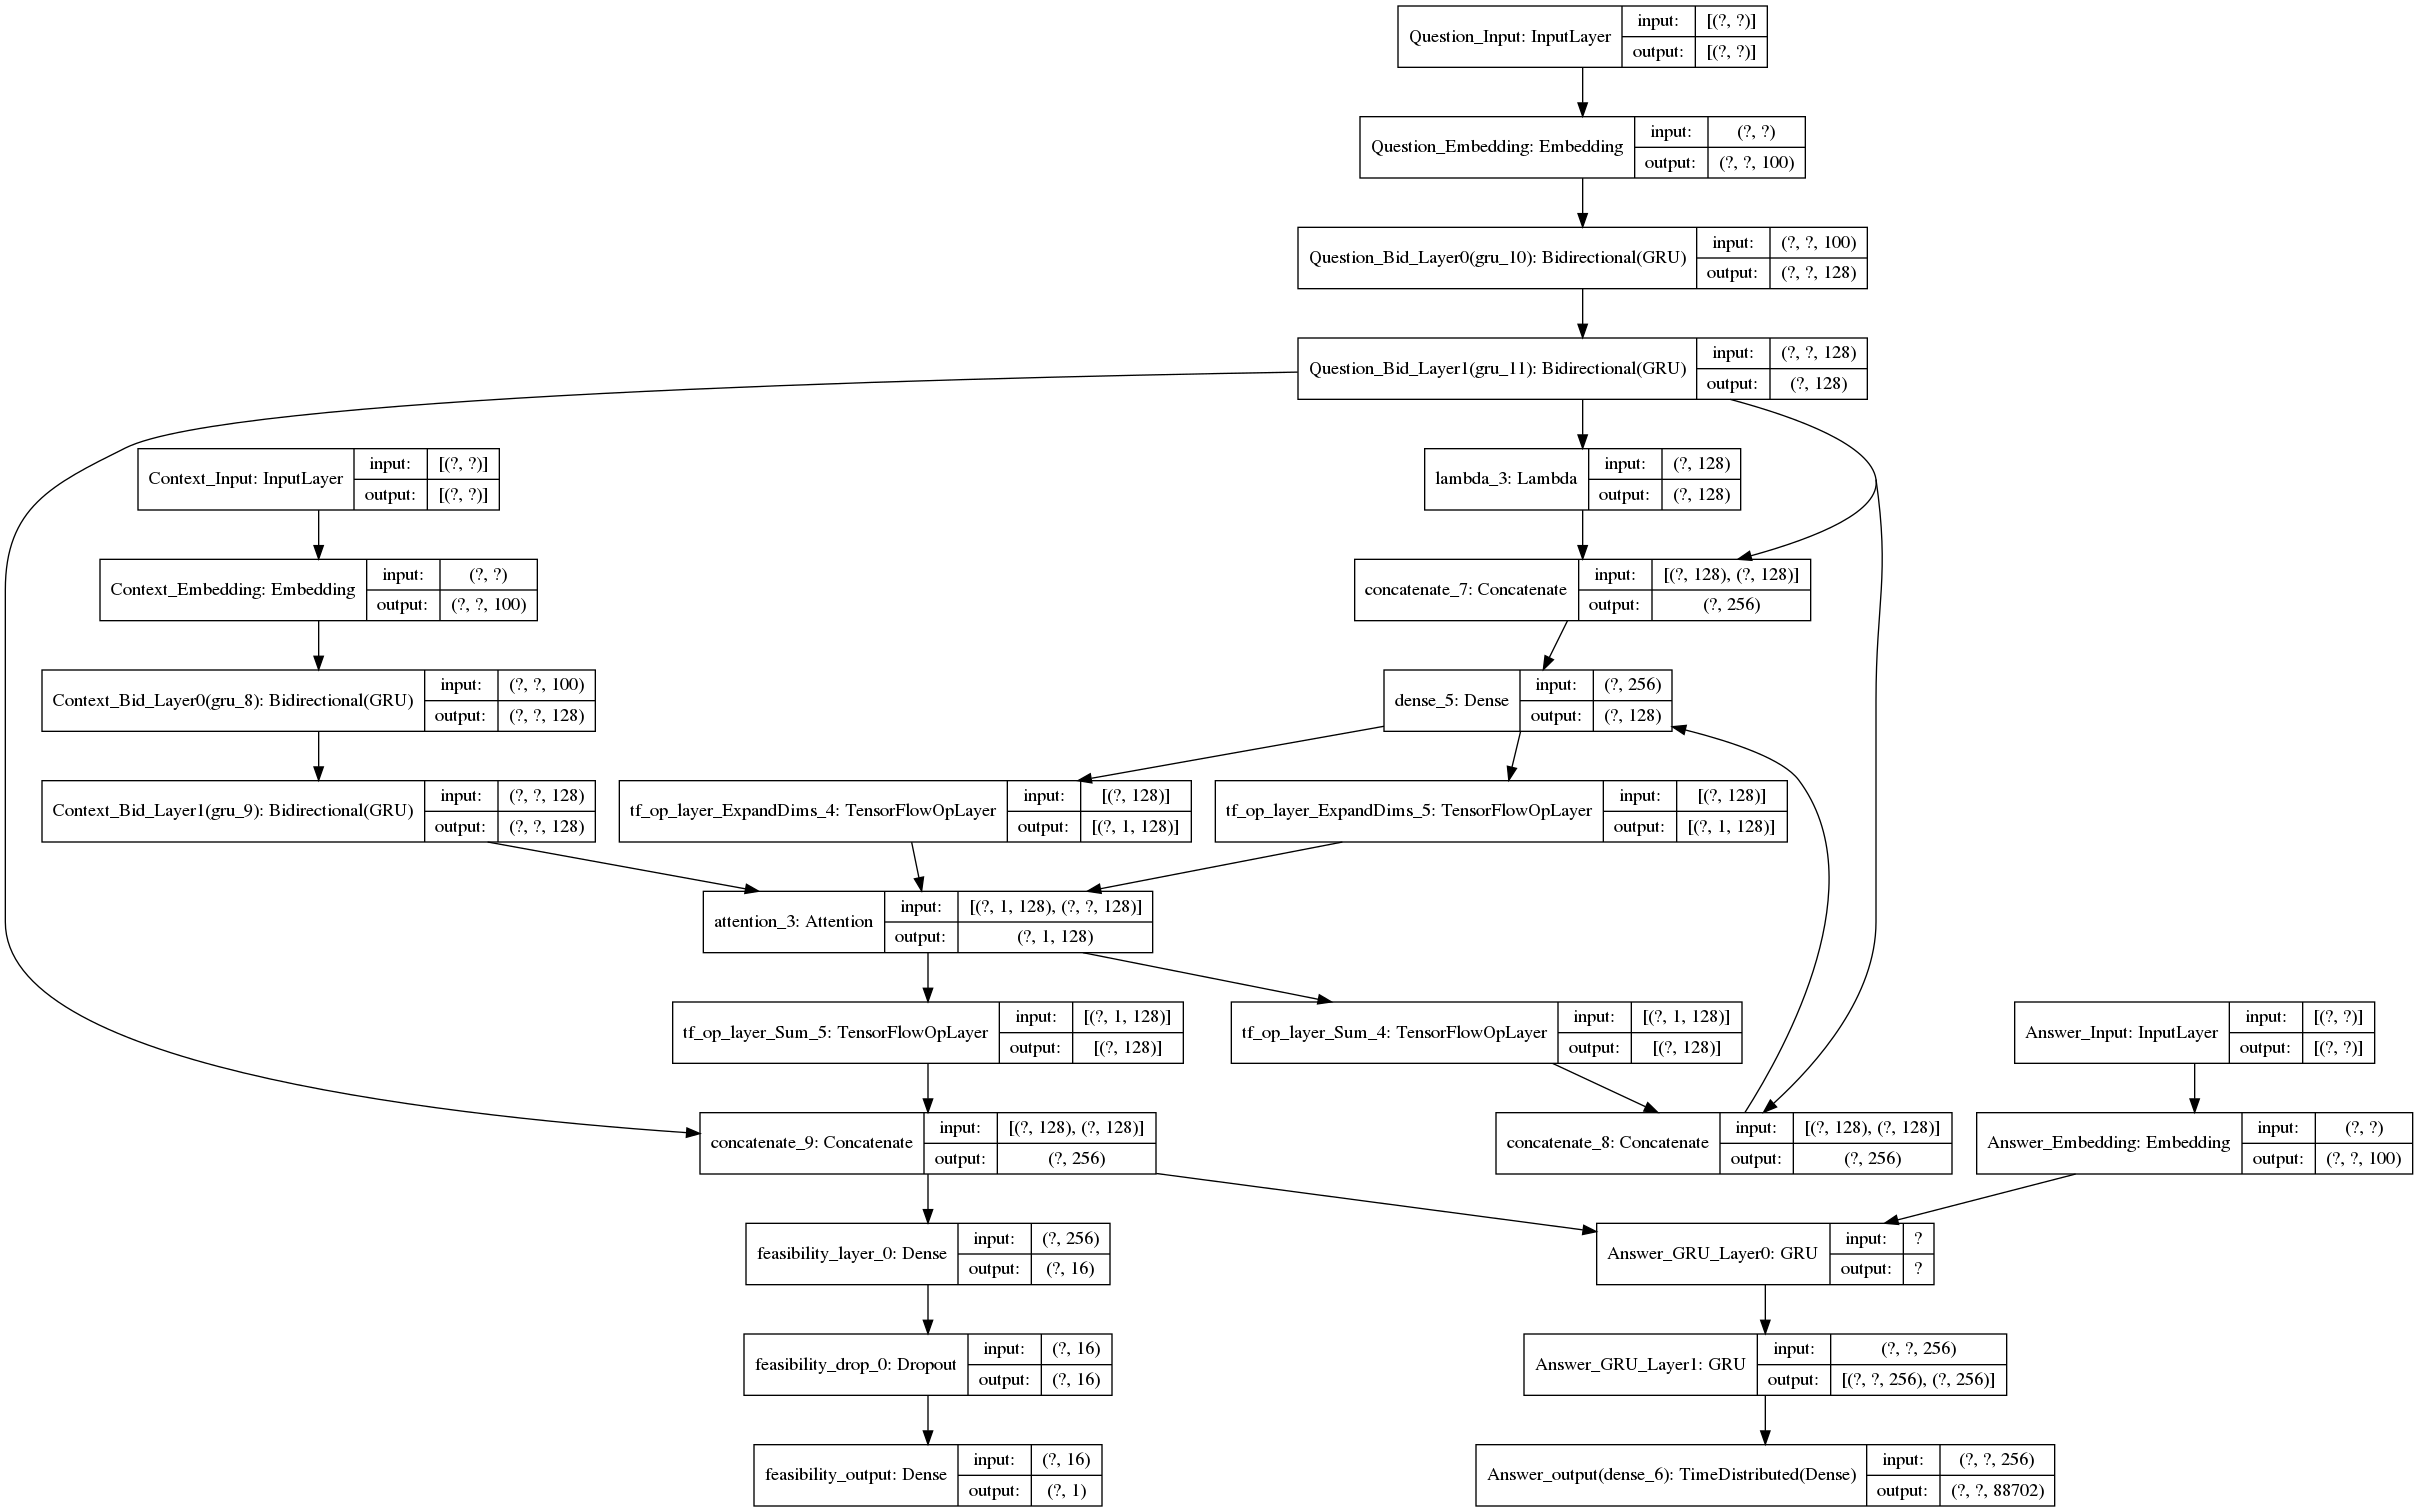

In [95]:
from tensorflow.keras.utils import plot_model
import pydot
plot_model(model2,show_shapes=True,to_file="model.png")

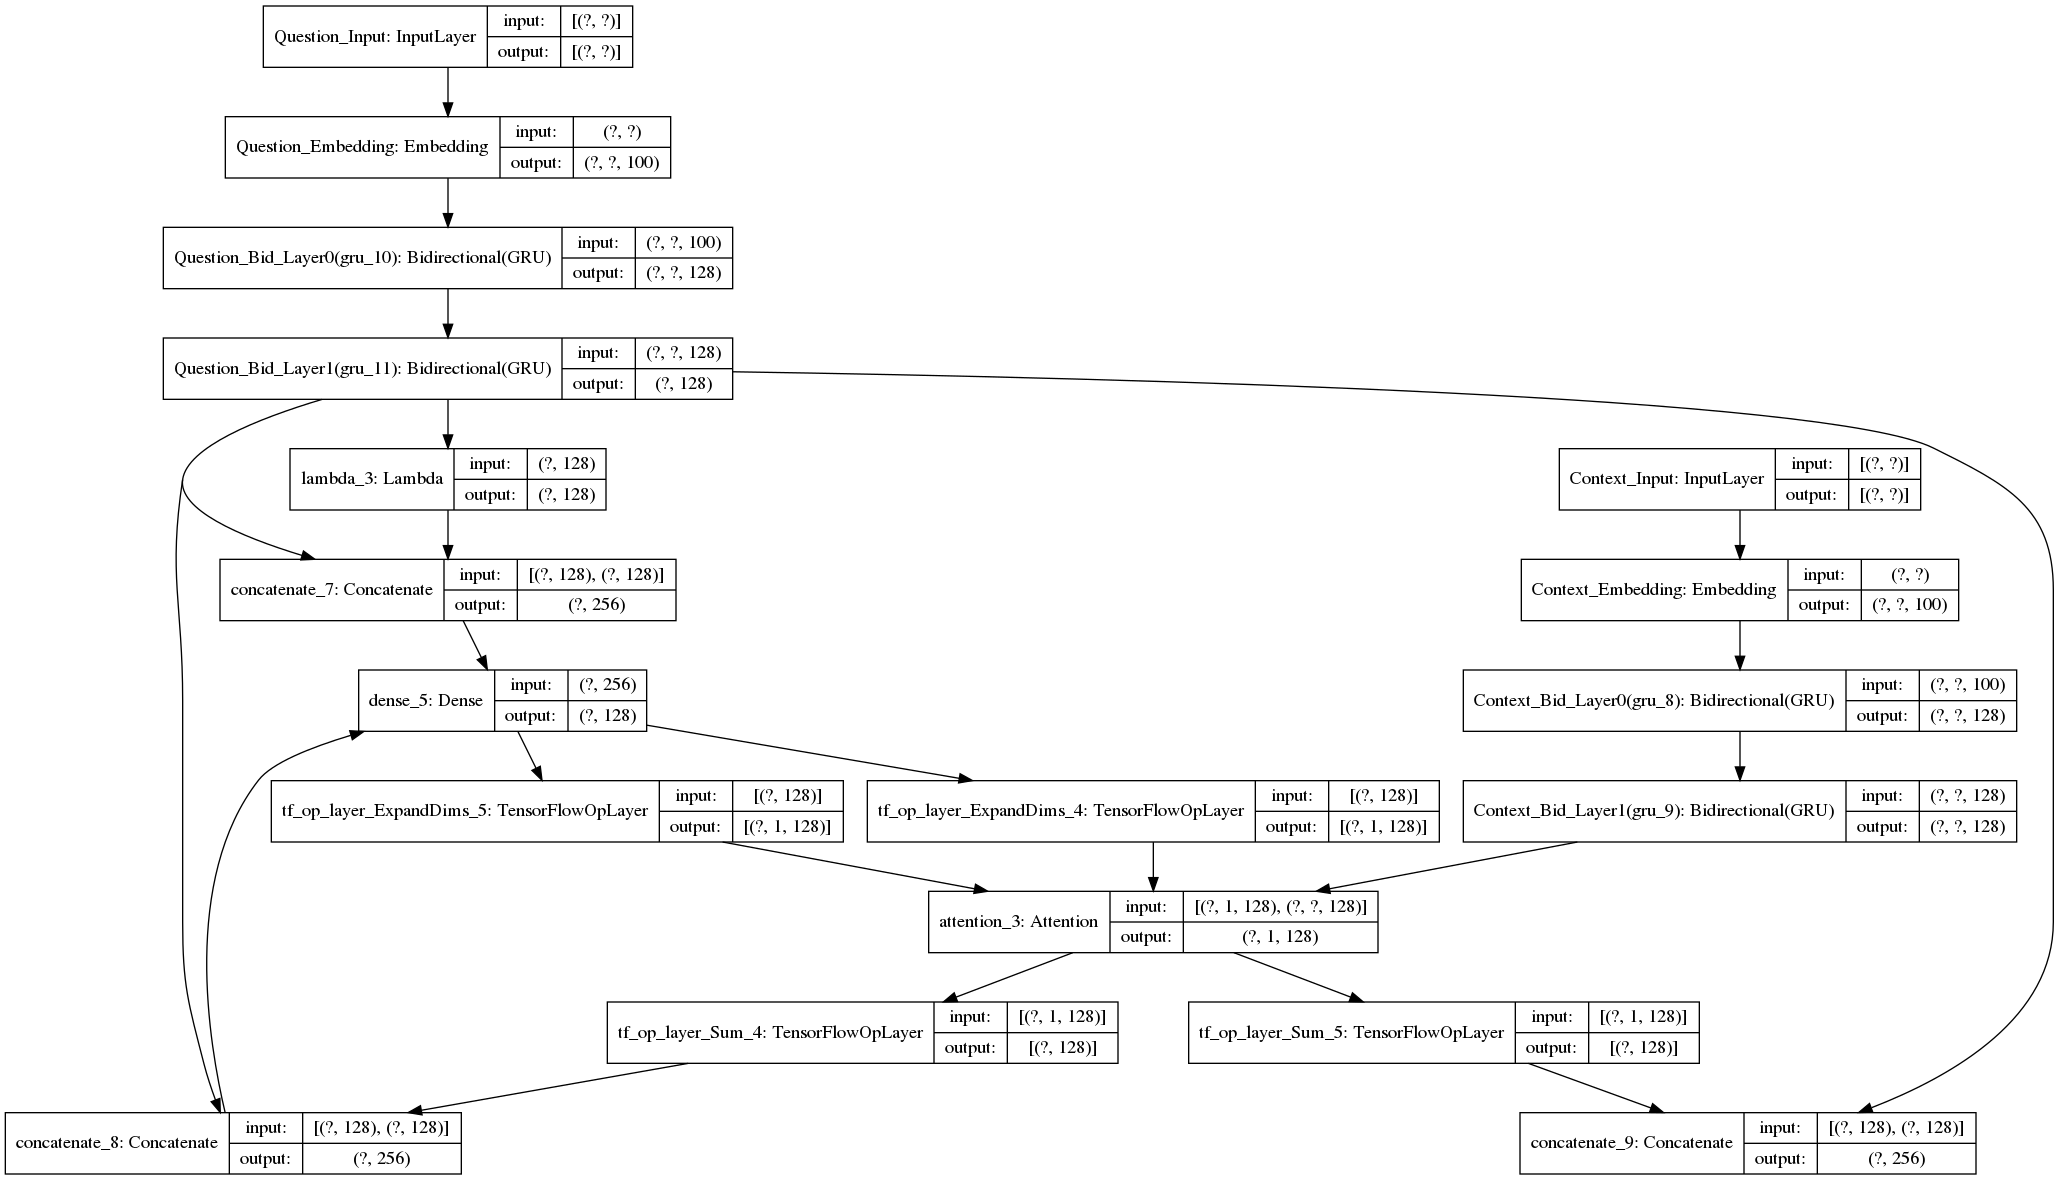

In [96]:
plot_model(encoder_model, show_shapes=True, to_file="encoder.png")

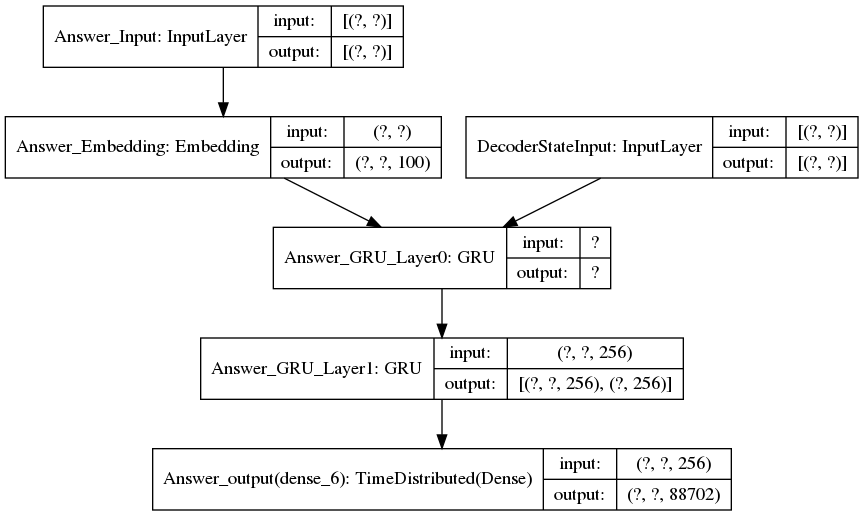

In [97]:
plot_model(decoder_model, show_shapes=True, to_file="decoder.png")

In [2]:
g = [1,2,3]
g[:10]

[1, 2, 3]

In [4]:
import tensorflow as tf
tf.expand_dims([1]*3,1)

<tf.Tensor: shape=(3, 1), dtype=int32, numpy=
array([[1],
       [1],
       [1]], dtype=int32)>